# AI靶场演示案例

AI靶场通过对敏感数据发现、数据抽样等方式，将数据从运行环境经过抽样之后上送到调试环境中，数据分析师在只能看到抽样数据的前提下，进行数据分析和建模操作。

## 案例背景

我们的演示数据来自一家知名保险公司及其合作的医疗机构，保险公司希望通过建立机器学习模型，评估当年已经购买人寿保险的客户在次年续保的意愿。

过去的人寿保险的推销需要逐个向客户进行推销，在不清楚客户的续保意愿流程繁琐且战线长，大大降低了保险公司的营销效率，增加了营销成本。

该问题预测的标签为：用户对当前保险方案的满意度。

由不满意到满意共有8个标签，1代表非常不满意，从1 开始满意度逐渐增加，8代表非常满意。

该案例中，保险公司用于评价模型的评价指标为“Quadratic_Weighted_Kappa”（二次加权Kappa），该指标通常落在 0 ～ 1 之间，越大效果越好。

## 分析开始

数据分析师首先从AI靶场导入抽样数据，然后再进行必要的数据探索。

In [1]:
#导入必要的包

#计算与可视化
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

#评估指标、编码与模型
from  sklearn.metrics import accuracy_score,  auc, confusion_matrix, roc_auc_score, classification_report,cohen_kappa_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import xgboost as xgb
from scipy.optimize import fmin_powell
#from ml_metrics import quadratic_weighted_kappa

In [2]:
# 导入数据集 保险数据集-训练-抽样
 
import wfio
_INPUT = '{"type":15,"uri":"awss373bfb917c36042e388d84d6d8eb8cb1c/sd_8bd2f53d45fc4c7fb1cf80119bef3a33"}'
 
# 读取并返回对应的Dataframe
# 参数as_spark: 为True返回Spark DataFrame，为False返回Pandas DataFrame，默认为False 
train = wfio.read_dataframe(_INPUT,as_spark = False)

In [3]:
# 导入数据集 保险数据集-测试-抽样
 
import wfio
_INPUT2 = '{"type":15,"uri":"awss31accaeb1d1144957af03f06e7edc9923/sd_dcad6eb6475b4248aba0f5de5f7af39f"}'
 
# 读取并返回对应的Dataframe
# 参数as_spark: 为True返回Spark DataFrame，为False返回Pandas DataFrame，默认为False 
test = wfio.read_dataframe(_INPUT2,as_spark = False)

通过查看数据的形状、表头等信息，确认数据导入正确。

In [4]:
test.shape

(4157, 127)

In [5]:
#查看训练集数据
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1782 entries, 0 to 1781
Columns: 127 entries, product_info_1 to response
dtypes: float64(18), int64(108), object(1)
memory usage: 1.7+ MB
None


,product_info_1,product_info_2,product_info_3,product_info_4,product_info_5,product_info_6,product_info_7,ins_age,ht,wt,...,medical_keyword_40,medical_keyword_41,medical_keyword_42,medical_keyword_43,medical_keyword_44,medical_keyword_45,medical_keyword_46,medical_keyword_47,medical_keyword_48,response
0,1,D3,26,0.230769,2,3,1,0.402985,0.781818,0.418410,...,0,0,0,0,0,0,0,0,0,1
1,1,D4,26,1.000000,2,3,1,0.223881,0.763636,0.297071,...,0,0,0,0,0,0,0,0,0,7
2,1,D2,29,0.487179,2,3,1,0.253731,0.872727,0.320084,...,1,0,0,0,0,0,0,0,0,2
3,1,C3,26,0.487179,2,1,1,0.283582,0.690909,0.303347,...,0,0,0,0,0,0,0,0,0,6
4,1,D4,26,0.487179,2,1,1,0.283582,0.690909,0.253138,...,0,0,0,0,0,0,0,0,0,8


# 查看数据

## 总体说明：
该训练集的抽样数据一共有**4157**条样本， 每条样本有**127**个字段特征。其中，有18个`float64`类型的字段, 108个`int64`类型的字段,1个 `object`类型的字段。

## 字段含义说明：
* Ins_Age：客户年龄（标准化处理过的结果）
* Ht：客户身高（标准化处理过的结果）
* Wt：客户体重（标准化处理过的结果）
* BMI：客户身体健康指数（标准化处理过的结果）
* Product_Info_1-7：客户产品相关的变量（处理后的结果）
* Employment_Info_1-6：有关客户工作经验的变量（处理后的结果）
* InsuredInfo_1-6：有关客户的信息变量（处理后的结果）
* Insurance_History_1-9：有关客户过去的保险信息（处理后的结果）
* Family_Hist_1-5:有关客户家庭相关的信息（处理后的结果）
* Medical_History_1-41：有关客户的医疗史信息（处理后的结果）
* Medical_Keyword_1-48：与该保险相关或不相关的医疗信息？？？不太确定含义，该信息是伪变量
* Response：响应值（1-8级：1，2，3，4，5，6，7，8）(本任务的目标变量)

## 字段类型说明：
* 连续值变量：
<p> Product_Info_4, Ins_Age, Ht, Wt, BMI, Employment_Info_1, Employment_Info_4, Employment_Info_6, Insurance_History_5, Family_Hist_2, Family_Hist_3, Family_Hist_4, Family_Hist_5.<p> 

* 离散值变量：
<p> Medical_History_1, Medical_History_10, Medical_History_15, Medical_History_24, Medical_History_32
Medical_Keyword_1-48 are dummy variables.<p> 

* 无序的类别变量：
<p> Product_Info_1, Product_Info_2, Product_Info_3, Product_Info_5, Product_Info_6, Product_Info_7, Employment_Info_2, Employment_Info_3, Employment_Info_5, InsuredInfo_1, InsuredInfo_2, InsuredInfo_3, InsuredInfo_4, InsuredInfo_5, InsuredInfo_6, InsuredInfo_7, Insurance_History_1, Insurance_History_2, Insurance_History_3, Insurance_History_4, Insurance_History_7, Insurance_History_8, Insurance_History_9, Family_Hist_1, Medical_History_2, Medical_History_3, Medical_History_4, Medical_History_5, Medical_History_6, Medical_History_7, Medical_History_8, Medical_History_9, Medical_History_11, Medical_History_12, Medical_History_13, Medical_History_14, Medical_History_16, Medical_History_17, Medical_History_18, Medical_History_19, Medical_History_20, Medical_History_21, Medical_History_22, Medical_History_23, Medical_History_25, Medical_History_26, Medical_History_27, Medical_History_28, Medical_History_29, Medical_History_30, Medical_History_31, Medical_History_33, Medical_History_34, Medical_History_35, Medical_History_36, Medical_History_37, Medical_History_38, Medical_History_39, Medical_History_40, Medical_History_41

In [6]:
#找出object类型的特征
for f in train.columns:
    if train[f].dtype == 'object':
        print(f+'\n')
        print(train[f].unique())
        print(len(train[f].unique()))

product_info_2

['D3' 'D4' 'D2' 'C3' 'A7' 'B2' 'A8' 'A2' 'D1' 'A6' 'A1' 'A5' 'A3' 'A4'
 'E1' 'C1' 'C4' 'C2' 'B1']
19


**数据集中唯一的`object`类型特征是`Product_Info_2`**，该特征共19个取值，字符串形式是**字母+数字**

#  缺失值分析

在正式的建模之前，数据分析师通常会通过基本的分析进行

In [7]:
#缺失值分析函数
def missing_data(df):
    #缺失值个数统计
    all_null = df.isnull().sum()
    
    #缺失值百分比统计
    percent = df.isnull().mean()*100
    
    #合并缺失值个数与百分比统计
    miss_table = pd.concat([all_null, percent], axis=1, keys=['MissTotalNum', 'MissPercent'])
    
    #添加字段类型
    types = []
    for col in df.columns:
        dtype = str(df[col].dtype)
        types.append(dtype)
    miss_table['Types'] = types
    return miss_table

In [8]:
#查看训练集缺失值比例
print(missing_data(train)['MissPercent'].sort_values(ascending=False)[:20])
#打印有缺失值的字段
print("存在缺失值的字段：\n")
[train.columns[train.isnull().mean() > 0]]

medical_history_10     99.046016
medical_history_32     97.755331
medical_history_24     93.434343
medical_history_15     76.655443
family_hist_5          70.089787
family_hist_3          56.397306
family_hist_2          49.046016
insurance_history_5    42.199776
family_hist_4          32.267116
employment_info_6      17.508418
medical_history_1      14.534231
employment_info_4      10.886644
medical_history_2       0.000000
medical_history_3       0.000000
medical_history_9       0.000000
medical_history_5       0.000000
medical_history_6       0.000000
medical_history_7       0.000000
medical_history_8       0.000000
medical_history_4       0.000000
Name: MissPercent, dtype: float64
存在缺失值的字段：



[Index(['employment_info_4', 'employment_info_6', 'insurance_history_5',
        'family_hist_2', 'family_hist_3', 'family_hist_4', 'family_hist_5',
        'medical_history_1', 'medical_history_10', 'medical_history_15',
        'medical_history_24', 'medical_history_32'],
       dtype='object')]

In [9]:
#查看测试集缺失值比例
print(missing_data(test)['MissPercent'].sort_values(ascending=False)[:20])

#打印有缺失值的字段
print("存在缺失值的字段：\n")
[test.columns[test.isnull().mean() > 0]]

medical_history_10     99.158047
medical_history_32     98.051479
medical_history_24     93.384652
medical_history_15     75.390907
family_hist_5          71.758480
family_hist_3          57.950445
family_hist_2          47.510224
insurance_history_5    42.001443
family_hist_4          31.320664
employment_info_6      17.825355
medical_history_1      15.564109
employment_info_4      12.509021
employment_info_1       0.024056
medical_history_17      0.000000
medical_history_7       0.000000
medical_history_23      0.000000
medical_history_22      0.000000
medical_history_21      0.000000
medical_history_2       0.000000
medical_history_3       0.000000
Name: MissPercent, dtype: float64
存在缺失值的字段：



[Index(['employment_info_1', 'employment_info_4', 'employment_info_6',
        'insurance_history_5', 'family_hist_2', 'family_hist_3',
        'family_hist_4', 'family_hist_5', 'medical_history_1',
        'medical_history_10', 'medical_history_15', 'medical_history_24',
        'medical_history_32'],
       dtype='object')]

## 缺失值探索结果
测试集和训练集缺失值的分布基本一致，也是Medical_History_10 、Medical_History_32 、Medical_History_24 和Medical_History_15四个字段的缺失值百分比高于75%,且存在缺失值的字段也是这10个字段：'Employment_Info_1', 'Employment_Info_4', 'Employment_Info_6','Insurance_History_5', 'Family_Hist_2', 'Family_Hist_3','Family_Hist_4', 'Family_Hist_5', 'Medical_History_1'

In [10]:
#将测试集中缺失值占比高于百分之75的字段特征直接删除处理
#test=test[test.columns[test.isnull().mean() <= 0.75]]

In [11]:
#再次查看数据
print(train.isnull().mean().sort_values(ascending=False))

#print(test.isnull().mean().sort_values(ascending=False))

medical_history_10    0.990460
medical_history_32    0.977553
medical_history_24    0.934343
medical_history_15    0.766554
family_hist_5         0.700898
                        ...   
medical_keyword_12    0.000000
medical_keyword_13    0.000000
medical_keyword_14    0.000000
medical_keyword_15    0.000000
product_info_1        0.000000
Length: 127, dtype: float64


**打印具有空值的列名和数据类型**

In [12]:
#进一步查看数值型空值情况
list_train=train.columns[train.isnull().mean() > 0].tolist()
for i in range(0,len(list_train)):
    print('column name: ',list_train[i],' Dtype:',train[list_train[i]].dtypes, 'unique:',train[list_train[i]].unique().shape[0])

column name:  employment_info_4  Dtype: float64 unique: 113
column name:  employment_info_6  Dtype: float64 unique: 141
column name:  insurance_history_5  Dtype: float64 unique: 192
column name:  family_hist_2  Dtype: float64 unique: 56
column name:  family_hist_3  Dtype: float64 unique: 74
column name:  family_hist_4  Dtype: float64 unique: 61
column name:  family_hist_5  Dtype: float64 unique: 69
column name:  medical_history_1  Dtype: float64 unique: 64
column name:  medical_history_10  Dtype: float64 unique: 9
column name:  medical_history_15  Dtype: float64 unique: 129
column name:  medical_history_24  Dtype: float64 unique: 55
column name:  medical_history_32  Dtype: float64 unique: 10


**从结果看，后五个字段特征的取值个数均在164个以内，因此将对这五个特征众数填补空值，其他用均值填补空值。**

In [13]:
#空值处理
for column in list_train:

    if train[column].unique().shape[0] >200: #均值填充
        train[column].fillna(train[column].mean(), inplace=True)
    else:  #众数填充
        train[column].fillna(float(train[column].mean()), inplace=True)  
    
    #else:  #中位数填充
    #   train[columtrain[column].mode()n].fillna(train[column].median(), inplace=True)   
train.isnull().sum().sort_values(ascending=False)

response              0
medical_history_10    0
family_hist_2         0
family_hist_3         0
family_hist_4         0
                     ..
medical_keyword_12    0
medical_keyword_13    0
medical_keyword_14    0
medical_keyword_15    0
product_info_1        0
Length: 127, dtype: int64

In [14]:
train.head()

,product_info_1,product_info_2,product_info_3,product_info_4,product_info_5,product_info_6,product_info_7,ins_age,ht,wt,...,medical_keyword_40,medical_keyword_41,medical_keyword_42,medical_keyword_43,medical_keyword_44,medical_keyword_45,medical_keyword_46,medical_keyword_47,medical_keyword_48,response
0,1,D3,26,0.230769,2,3,1,0.402985,0.781818,0.418410,...,0,0,0,0,0,0,0,0,0,1
1,1,D4,26,1.000000,2,3,1,0.223881,0.763636,0.297071,...,0,0,0,0,0,0,0,0,0,7
2,1,D2,29,0.487179,2,3,1,0.253731,0.872727,0.320084,...,1,0,0,0,0,0,0,0,0,2
3,1,C3,26,0.487179,2,1,1,0.283582,0.690909,0.303347,...,0,0,0,0,0,0,0,0,0,6
4,1,D4,26,0.487179,2,1,1,0.283582,0.690909,0.253138,...,0,0,0,0,0,0,0,0,0,8


In [15]:
#测试集数值型空值情况
list_test=test.columns[test.isnull().mean() > 0].tolist()
for i in range(0,len(list_test)):
    print('column name: ',list_test[i],' Dtype:',test[list_test[i]].dtypes, 'unique:',test[list_test[i]].unique().shape[0])

column name:  employment_info_1  Dtype: float64 unique: 380
column name:  employment_info_4  Dtype: float64 unique: 185
column name:  employment_info_6  Dtype: float64 unique: 260
column name:  insurance_history_5  Dtype: float64 unique: 323
column name:  family_hist_2  Dtype: float64 unique: 59
column name:  family_hist_3  Dtype: float64 unique: 79
column name:  family_hist_4  Dtype: float64 unique: 63
column name:  family_hist_5  Dtype: float64 unique: 75
column name:  medical_history_1  Dtype: float64 unique: 96
column name:  medical_history_10  Dtype: float64 unique: 17
column name:  medical_history_15  Dtype: float64 unique: 209
column name:  medical_history_24  Dtype: float64 unique: 79
column name:  medical_history_32  Dtype: float64 unique: 19


In [16]:
#测试集空值处理
for column in list_test:
    
    test[column].fillna(test[column].mean(), inplace=True)
    #if test[column].unique().shape[0] >200: #均值填充
    #    test[column].fillna(test[column].mean(), inplace=True)
    #else:  #众数填充
    #    test[column].fillna(float(test[column].mode()), inplace=True)  
    
    #else:  #中位数填充
    #   train[columtrain[column].mode()n].fillna  
test.isnull().sum().sort_values(ascending=False)

response              0
medical_history_10    0
family_hist_2         0
family_hist_3         0
family_hist_4         0
                     ..
medical_keyword_12    0
medical_keyword_13    0
medical_keyword_14    0
medical_keyword_15    0
product_info_1        0
Length: 127, dtype: int64

## 数据探索

紧接着，数据分析师对数据的特征、标签的分布进行探索，并结合自己的领域知识，在后续的建模过程中加以考虑。

首先是针对标签分布的探索。

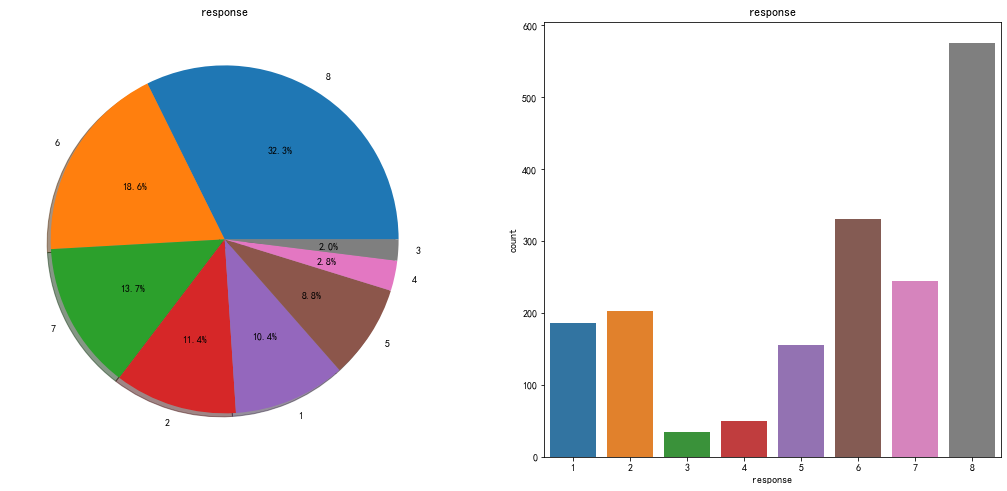

In [17]:
f,ax=plt.subplots(1,2,figsize=(18,8))
train['response'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('response')
ax[0].set_ylabel('')
sns.countplot('response',data=train,ax=ax[1])
ax[1].set_title('response')
plt.show()

**第八类的数据量最大，最少1.7%，与最多的19.1%相差10倍**
**数据存在极大的不平衡问题**

## 探索特征的分布

数据分析师根据领域知识，对数据表中的特征进行数据探索。

* **Weight**： 客户的体重信息

In [18]:
#基本信息描述
train["wt"].describe(percentiles=[.8, .9, .95, .98, .999])

count    1782.000000
mean        0.294610
std         0.091366
min         0.102510
50%         0.288703
80%         0.361925
90%         0.414226
95%         0.460042
98%         0.508368
99.9%       0.665272
max         0.705021
Name: wt, dtype: float64

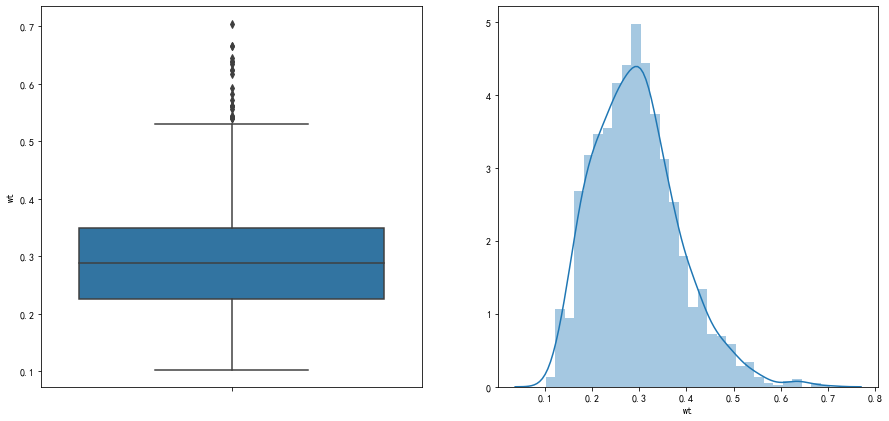

In [19]:
#箱状图与密度直方图
f, axes = plt.subplots(1, 2, figsize=(15,7))
sns.boxplot(x = 'wt', data=train,  orient='v' , ax=axes[0])
sns.distplot(train['wt'],  ax=axes[1])

* **Height**：客户的身高信息

In [20]:
#基本信息描述
train["ht"].describe(percentiles=[.8, .9, .95, .98, .999])

count    1782.000000
mean        0.707642
std         0.075020
min         0.381818
50%         0.709091
80%         0.781818
90%         0.800000
95%         0.818182
98%         0.854545
99.9%       0.909091
max         0.945455
Name: ht, dtype: float64

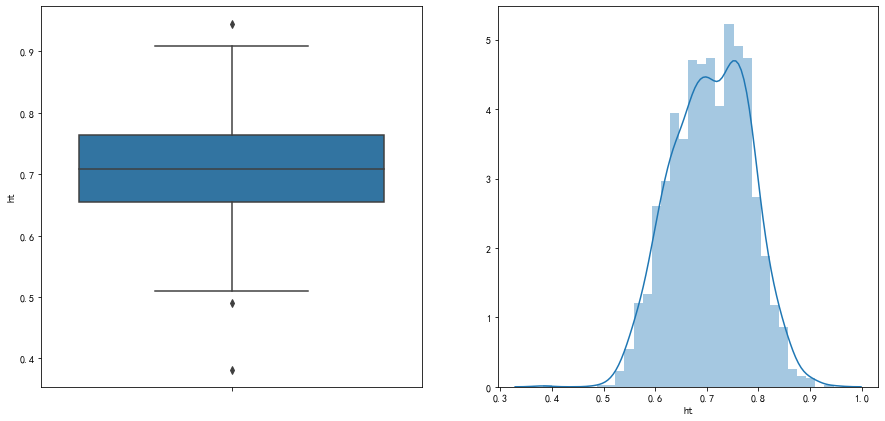

In [21]:
f, axes = plt.subplots(1, 2, figsize=(15,7))
sns.boxplot(x = 'ht', data=train,  orient='v' , ax=axes[0])
sns.distplot(train['ht'],  ax=axes[1])

* **BMI**：客户的BMI信息

In [22]:
#基本信息描述
train["bmi"].describe(percentiles=[.8, .9, .95, .98, .999])

count    1782.000000
mean        0.472616
std         0.127382
min         0.192143
50%         0.457067
80%         0.563567
90%         0.632699
95%         0.716672
98%         0.810920
99.9%       1.000000
max         1.000000
Name: bmi, dtype: float64

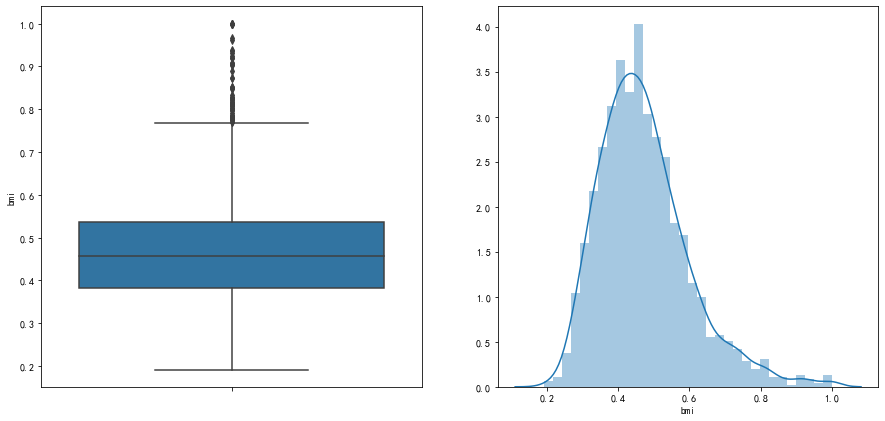

In [23]:
f, axes = plt.subplots(1, 2, figsize=(15,7))
sns.boxplot(x = 'bmi', data=train,  orient='v' , ax=axes[0])
sns.distplot(train['bmi'],  ax=axes[1])

* **Age**：客户的年龄信息

In [24]:
#基本信息描述
train["ins_age"].describe(percentiles=[.8, .9, .95, .98, .999])

count    1782.000000
mean        0.401452
std         0.198442
min         0.000000
50%         0.402985
80%         0.597015
90%         0.671642
95%         0.716418
98%         0.766866
99.9%       0.860552
max         0.895522
Name: ins_age, dtype: float64

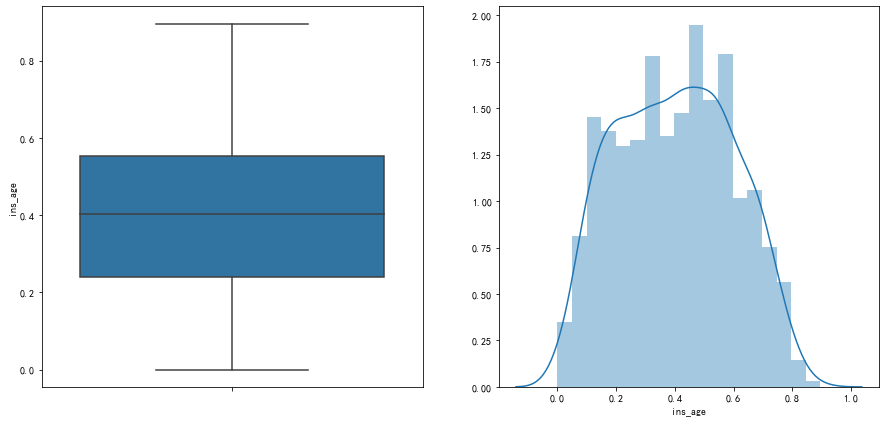

In [25]:
f,axes=plt.subplots(1,2,figsize=(15,7))
sns.boxplot(x = 'ins_age', data=train,  orient='v' , ax=axes[0])
sns.distplot(train['ins_age'],ax=axes[1])

**对于前三个特征，从箱状图可以看出有异常值，但是这些数据是经过处理的，无法确定是异常值，不予处理**
**对于年龄特征，不存在异常值**

**根据BMI，AGE，HEIGHT和WEIGHT的值对它们进行离散化处理**

In [26]:
# BMI离散化处理
conditions = [
    (train['bmi'] <= train['bmi'].quantile(0.25)),
    (train['bmi'] > train['bmi'].quantile(0.25)) & (train['bmi'] <= train['bmi'].quantile(0.75)),
    (train['bmi'] > train['bmi'].quantile(0.75))]

choices = ['under_weight', 'average', 'overweight']

train['BMI_Wt'] = np.select(conditions, choices)

# 年龄离散化处理
conditions = [
    (train['ins_age'] <= train['ins_age'].quantile(0.25)),
    (train['ins_age'] > train['ins_age'].quantile(0.25)) & (train['ins_age'] <= train['ins_age'].quantile(0.75)),
    (train['ins_age'] > train['ins_age'].quantile(0.75))]

choices = ['young', 'average', 'old']
train['Old_Young'] = np.select(conditions, choices)

# 身份离散化处理
conditions = [
    (train['ht'] <= train['ht'].quantile(0.25)),
    (train['ht'] > train['ht'].quantile(0.25)) & (train['ht'] <= train['ht'].quantile(0.75)),
    (train['ht'] > train['ht'].quantile(0.75))]

choices = ['short', 'average', 'tall']

train['Short_Tall'] = np.select(conditions, choices)

# 体重离散化处理
conditions = [
    (train['wt'] <= train['wt'].quantile(0.25)),
    (train['wt'] > train['wt'].quantile(0.25)) & (train['wt'] <= train['wt'].quantile(0.75)),
    (train['wt'] > train['wt'].quantile(0.75))]

choices = ['thin', 'average', 'fat']

train['Thin_Fat'] = np.select(conditions, choices)

### 在其他特征的探索阶段，为了方便分析，将标签转化为二分类

**0-7作为1类， 8作为一类进行标签制作**

In [27]:
#制作标签函数
def new_target(row):
    if (row['response']<=7) & (row['response']>=0):
        val=0
    elif (row['response']==8):
        val=1
    else:
        val=-1
    return val

In [28]:
#保存一份原始数据集
new_data=train.copy()

In [29]:
#产生新的标签列
new_data['Final_Response']=new_data.apply(new_target,axis=1)

In [30]:
new_data['Final_Response'].value_counts()

0    1206
1     576
Name: Final_Response, dtype: int64

Text(0.5, 1.0, 'Distribution of rows by response categories')

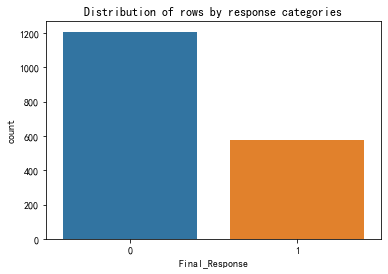

In [31]:
#查看新的标签分布
sns.countplot(x=new_data.Final_Response).set_title('Distribution of rows by response categories')

In [32]:
#删除旧的标签列
new_data.drop(['response'],axis=1,inplace=True)
train=new_data

In [33]:
del new_data

In [34]:
#重命名
train.rename(columns={'Final_Response':'response'},inplace=True)

## 查看新的特征在新的标签上的分布

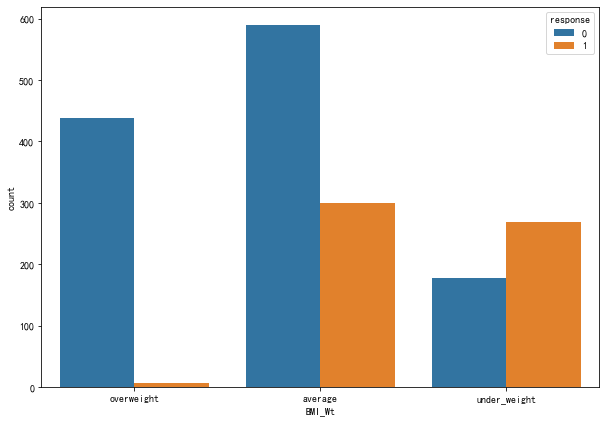

In [35]:
plt.figure(figsize=(10,7))
sns.countplot(x = 'BMI_Wt', hue = 'response', data = train)

**从此图可以看出，身体指数overweight的客户响应值为8的概率极小**

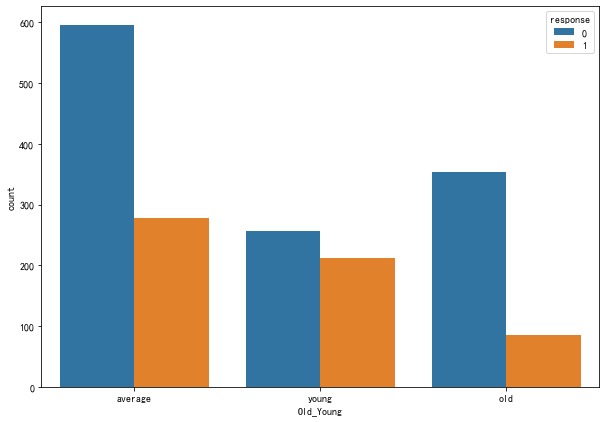

In [36]:
plt.figure(figsize=(10,7))
sns.countplot(x = 'Old_Young', hue = 'response', data = train)

**从上图可以看出，年长的客户响应值为8的概率较小**

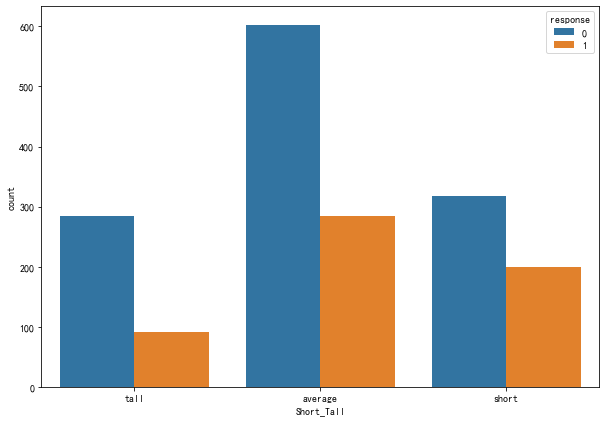

In [37]:
plt.figure(figsize=(10,7))
sns.countplot(x = 'Short_Tall', hue = 'response', data = train)

**从上图可以看出，身高对于客户意愿的影响较小**

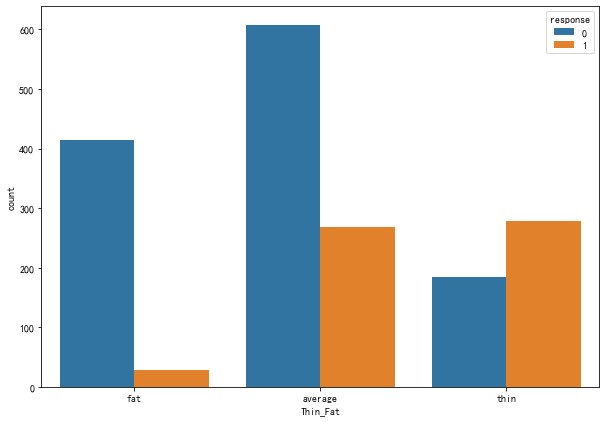

In [38]:
plt.figure(figsize=(10,7))
sns.countplot(x = 'Thin_Fat', hue = 'response', data = train)

**而经过以上的柱状图，过于肥胖的人群，意愿为8的概率极小**

### 构建新的特征

数据分析师根据经验，将年长 或者 体重过重 或者 MBI指数底的客户定义为：属于危险指数较高的人群。

In [39]:
def new_target(row):
    if (row['BMI_Wt']=='overweight') or (row['Old_Young']=='old')  or (row['Thin_Fat']=='fat'):
        val='extremely_risky'
    else:
        val='not_extremely_risky'
    return val

train['extreme_risk'] = train.apply(new_target,axis=1)

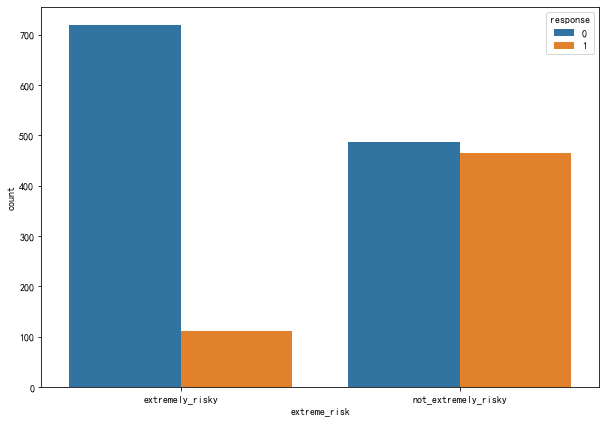

In [40]:
#查看新特征的目标值分布
plt.figure(figsize=(10,7))
sns.countplot(x = 'extreme_risk', hue = 'response', data = train)

**但是通过分析发现，风险值高的客户，响应值为8的概率极小**

In [41]:
def new_target(row):
    if (row['BMI_Wt']=='average') or (row['Old_Young']=='average')  or (row['Thin_Fat']=='average'):
        val='average'
    else:
        val='non_average'
    return val

train['average_risk'] = train.apply(new_target,axis=1)

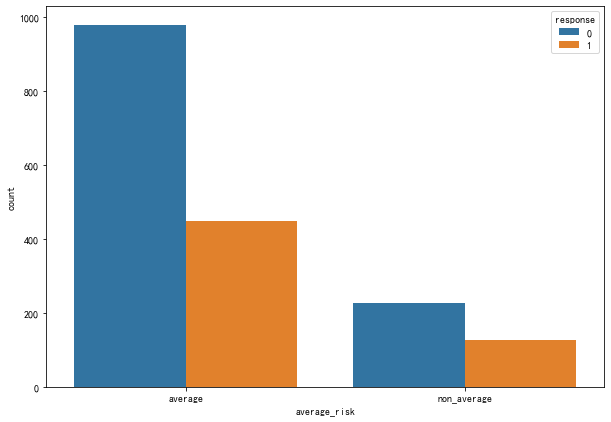

In [42]:
#查看新特征的目标值分布
plt.figure(figsize=(10,7))
sns.countplot(x = 'average_risk', hue = 'response', data = train)

**而处于中间范围的客户区别不大**

In [43]:
def new_target(row):
    if (row['BMI_Wt']=='under_weight') or (row['Old_Young']=='young')  or (row['Thin_Fat']=='thin'):
        val='low_end'
    else:
        val='non_low_end'
    return val

train['low_end_risk'] = train.apply(new_target,axis=1)

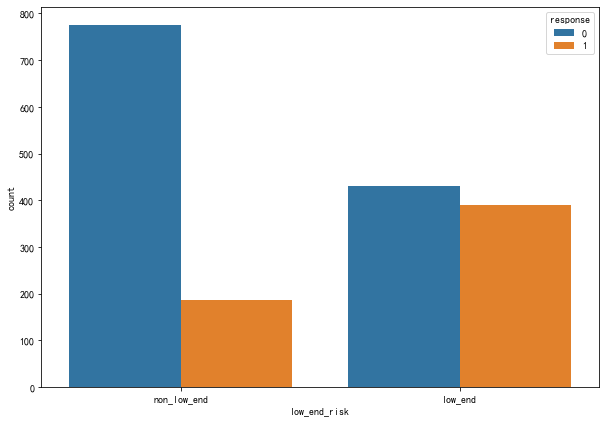

In [44]:
#查看新特征的目标值分布
plt.figure(figsize=(10,7))
sns.countplot(x = 'low_end_risk', hue = 'response', data = train)

**在身体BMI指数低、太瘦、太年幼的客户，响应值为8的概率也比较小**

##  对 object 特征`Product_Info_2`进行探索。

**数据集中唯一的`object`类型特征是`Product_Info_2`**，该特征共19个取值，字符串形式是**字母+数字**

In [45]:
#拆分Product_Info_2特征
train['Product_Info_2_char'] = train.product_info_2.str[0]
train['Product_Info_2_num'] = train.product_info_2.str[1]

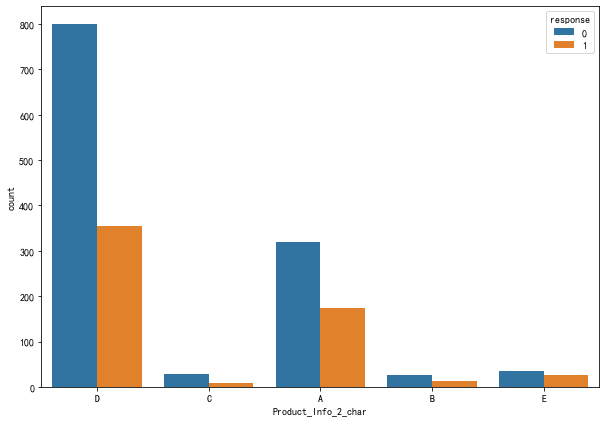

In [46]:
plt.figure(figsize=(10,7))
sns.countplot(x = 'Product_Info_2_char', hue = 'response', data = train)

**char为`A`和`D`的客户响应为8的概率比较小**

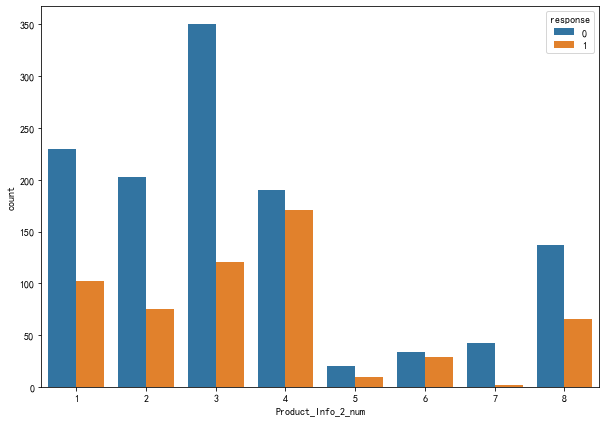

In [47]:
#查看num特征分布
plt.figure(figsize=(10,7))
sns.countplot(x = 'Product_Info_2_num', hue = 'response', data = train)

**`num` 为1，8，3，2，7的客户响应值为8的概率比较小**

## 构建新的特征

将`num`为 `1，8，3，2，7` 的客户 或者 char为`A`和`D`的客户视为**高风险**

In [48]:
def new_target4(row):
    if (row['Product_Info_2_num'] in list(['1','8','3','2','7'])) or  (row['Product_Info_2_char'] in list(['A', 'D'])):
        val='product2_risky'
    else:
        val='not_product2_risky'
    return val

train['product2_extreme_risk'] = train.apply(new_target4,axis=1)

# 特征探索

在分析完个别有特点的特征之后，数据分析师对其他特征进行统计上的分析，以便了解数据的总体情况。

## 探索医疗相关的特征

In [49]:
med_keyword_columns = train.columns[train.columns.str.startswith('medical_keyword_')]
train['Med_Keywords_Count'] = train[med_keyword_columns].sum(axis=1)   #求和（看病，吃药， ，，次数？？）
print(train['Med_Keywords_Count'].nunique())  # 11个取值，可作为新特征
train['Med_Keywords_Count'].unique()

12


array([ 3,  0,  1,  4,  2,  6,  7,  5,  8,  9, 11, 10])

In [50]:
med_keyword_columns = train.columns[train.columns.str.startswith('medical_keyword_')]
train['Med_Keywords_mean'] = train[med_keyword_columns].mean(axis=1)   #求均值（看病，吃药， ，，次数？？）
print(train['Med_Keywords_mean'].nunique())  # 11个取值，可作为新特征
train['Med_Keywords_mean'].unique()

12


array([0.0625    , 0.        , 0.02083333, 0.08333333, 0.04166667,
       0.125     , 0.14583333, 0.10416667, 0.16666667, 0.1875    ,
       0.22916667, 0.20833333])

## 探索家庭相关的特征

In [51]:
#求和
Family_Hist__keyword_columns = train.columns[train.columns.str.startswith('family_hist_')]
train['Family_Hist'] = train[Family_Hist__keyword_columns].sum(axis=1)
print(train['Family_Hist'].nunique())  # 2512个取值，没有区别，无参考价值
train['Family_Hist'].unique()

1313


array([5.07293598, 4.70545711, 3.81976615, ..., 4.03417999, 3.74636487,
       4.95329764])

In [52]:
## 均值
Family_Hist__keyword_columns = train.columns[train.columns.str.startswith('family_hist_')]
train['Family_Hist'] = train[Family_Hist__keyword_columns].mean(axis=1)
print(train['Family_Hist'].nunique())  # 2512个取值，无参考价值
train['Family_Hist'].unique()

1313


array([1.0145872 , 0.94109142, 0.76395323, ..., 0.806836  , 0.74927297,
       0.99065953])

In [53]:
## 均值
Family_Hist__keyword_columns = train.columns[train.columns.str.startswith('family_hist_')]
train['Family_Hist'] = train[Family_Hist__keyword_columns].mode(axis=1)
print(train['Family_Hist'].nunique())  # 144个取值，无参考价值
train['Family_Hist'].unique()

130


array([0.43710982, 0.35211268, 0.4084507 , 0.42253521, 0.3943662 ,
       0.46174105, 0.40196078, 0.45098039, 0.48395202, 0.07042253,
       0.21126761, 0.26760563, 0.28169014, 0.25352113, 0.38028169,
       0.39215686, 0.43661972, 0.28571429, 0.22535211, 0.10784314,
       0.42156863, 0.47887324, 0.38392857, 0.30985915, 0.16071429,
       0.33333333, 0.26470588, 0.39130435, 0.16901409, 0.36607143,
       0.31372549, 0.15492958, 0.23943662, 0.43137255, 0.45070423,
       0.29411765, 0.08823529, 0.12676056, 0.19607843, 0.46376812,
       0.23529412, 0.29577465, 0.3627451 , 0.28431373, 0.38235294,
       0.33802817, 0.32142857, 0.41071429, 0.18309859, 0.35714286,
       0.25892857, 0.30392157, 0.3125    , 0.35294118, 0.22321429,
       0.46478873, 0.27678571, 0.01960784, 0.41176471, 0.24637681,
       0.41964286, 0.34821429, 0.31884058, 0.40178571, 0.14705882,
       0.39285714, 0.32394366, 0.30357143, 0.26086957, 0.36619718,
       0.04901961, 0.47826087, 0.05797101, 0.37254902, 0.32352

## 探索医疗历史信息相关的特征

In [54]:
#求和
Medical_History_keyword_columns = train.columns[train.columns.str.startswith('medical_history_')]
train['Medical_History'] = train[Medical_History_keyword_columns].sum(axis=1)
print(train['Medical_History'].nunique())  # 1440个取值，无参考价值
train['Medical_History'].unique()

837


array([ 850.12099359,  569.12099359,  838.36858974,  318.37740385,
        896.12099359,  521.36858974,  407.36858974,  889.12099359,
        558.92861014,  813.36858974,  605.17620629,  389.36858974,
        560.92861014,  810.74358974, 1149.36858974,  681.12099359,
        505.12099359,  654.12099359,  953.12099359,  665.17620629,
        557.92861014,  536.12099359,  554.12099359,  910.12099359,
        551.12099359,  440.17620629, 1001.12099359,  529.12099359,
        542.30361014,  783.37740385,  407.12099359,  668.12099359,
        554.92861014,  501.12099359,  391.12099359,  744.36858974,
        662.12099359,  381.37740385, 1008.36858974,  410.43261655,
        502.12099359,  509.12099359,  882.12099359,  671.36858974,
        559.92861014,  768.36858974,  415.12099359,  550.12099359,
        894.12099359,  514.12099359,  797.36858974,  381.36858974,
        886.12099359,  911.12099359,  922.92861014,  555.92861014,
        762.12099359,  656.36858974,  541.12099359,  606.36858

In [55]:
#求和
Medical_History_keyword_columns = train.columns[train.columns.str.startswith('medical_history_')]
train['Medical_History'] = train[Medical_History_keyword_columns].mean(axis=1)
print(train['Medical_History'].nunique())  # 个1438取值，无参考价值
train['Medical_History'].unique()

837


array([20.73465838, 13.88099984, 20.44801438,  7.76530253, 21.8566096 ,
       12.71630707,  9.93581926, 21.68587789, 13.63240513, 19.83825829,
       14.76039528,  9.49679487, 13.68118561, 19.7742339 , 28.03338024,
       16.61270716, 12.32002423, 15.95417058, 23.2468535 , 16.22380991,
       13.60801488, 13.07612179, 13.51514619, 22.19807301, 13.44197545,
       10.73600503, 24.41758521, 12.90539009, 13.22691732, 19.10676595,
        9.92978033, 16.29563399, 13.53484415, 12.22246326,  9.53953643,
       18.15533146, 16.14929253,  9.3018879 , 24.59435585, 10.01055162,
       12.2468535 , 12.41758521, 21.51514619, 16.37484365, 13.65679537,
       18.74069731, 10.12490228, 13.41758521, 21.80782911, 12.53953643,
       19.44801438,  9.30167292, 21.61270716, 22.22246326, 22.51045391,
       13.55923439, 18.58831692, 16.00898999, 13.19807301, 14.7894778 ,
       12.27124375, 23.91142902, 21.93581926, 12.78343887, 17.03359522,
       12.14929253, 22.71026814, 12.19807301, 15.02734131, 24.98

# 将特征组合成新的特征

数据分析师根据领域知识，将特征进行一定程度的组合形成新的特征，在数据分析中新的特征可能会帮助模型形成更好的预测效果。

次数数据分析师将**特征bmi**和**特征wt**相乘，得到新的特征。

In [56]:
train["bmi_wt"] =  train["bmi"]  * train["wt"]

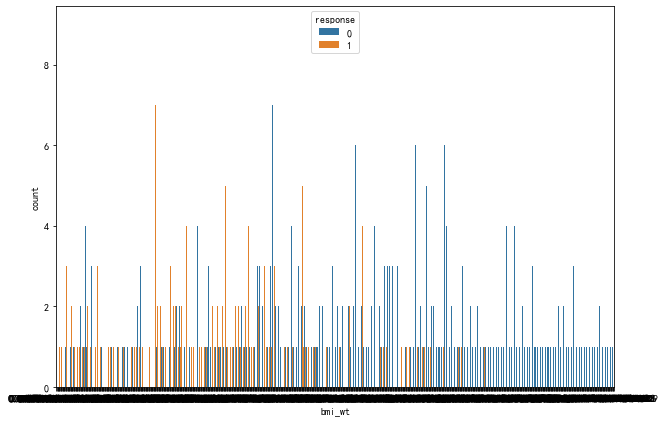

In [57]:
plt.figure(figsize=(10,7))
sns.countplot(x = 'bmi_wt', hue = 'response', data = train)

**可以看到，标签在新特征分布上具有较为明显的不同，黄色的1标签分布更加靠左，而蓝色的0标签分布更加靠右**

In [58]:
train["bmi_age"] =  train["bmi"]  * train["ins_age"]

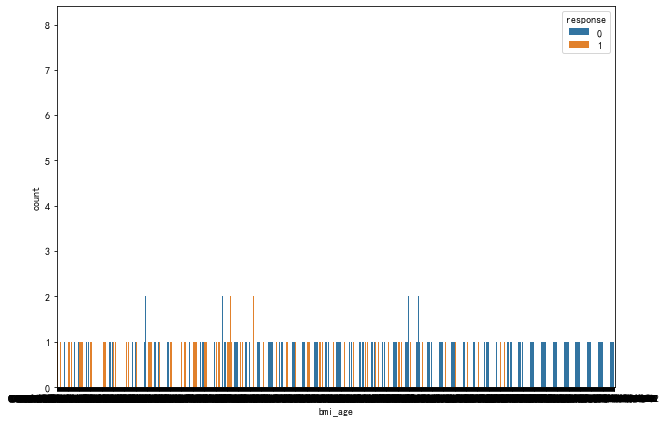

In [59]:
plt.figure(figsize=(10,7))
sns.countplot(x = 'bmi_age', hue = 'response', data = train)

# 开始进行特征工程和建模

通常，数据分析师会根据简单的分析，建立一个baseline 模型。

首先是一些基础的准备工作。

In [60]:
#导入必要包
import sklearn 
from sklearn import metrics
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
import copy 
from sklearn.metrics import cohen_kappa_score

from wf_analyse.analyse import base

# 导入数据集 保险数据集-训练-抽样
 
import wfio 
# 读取并返回对应的Dataframe
# 参数as_spark: 为True返回Spark DataFrame，为False返回Pandas DataFrame，默认为False 
df_train = wfio.read_dataframe(_INPUT,as_spark = False)
y_train = df_train['response'].to_numpy()
df_train.drop(["response"], axis = 1, inplace = True)

# 导入数据集 保险数据集-测试-抽样
 
import wfio 
# 读取并返回对应的Dataframe
# 参数as_spark: 为True返回Spark DataFrame，为False返回Pandas DataFrame，默认为False 
df_test = wfio.read_dataframe(_INPUT2,as_spark = False)

y_test = df_test['response'].to_numpy()
df_test.drop(["response"], axis = 1, inplace = True)

# 一些主要函数的定义

## 首先是确定 data_governance 的一个模版，便于之后训练和测试
## 由于返回值还是 df，所以可以层叠使用，每个 data_governance 函数实现一个功能

def data_governance_remove_nan(df_X): # 仅将不能处理的列删掉
    try:
        df_X.drop(["product_info_2"], axis = 1, inplace = True)
    except KeyError: 
        # 已经去除过了，ipython notebook 经常存在多次执行的事情
        pass
    return df_X

def data_governance_fill_empty(df_X): # 缺失值填充
    # 对离散变量进行填充
    df_X['medical_history_1'].fillna(df_X['medical_history_1'].mean(), inplace=True)
    df_X['medical_history_10'].fillna(df_X['medical_history_10'].mean(), inplace=True)
    df_X['medical_history_15'].fillna(df_X['medical_history_15'].mean(), inplace=True)
    df_X['medical_history_24'].fillna(df_X['medical_history_24'].mean(), inplace=True)
    df_X['medical_history_32'].fillna(df_X['medical_history_32'].mean(), inplace=True)
    # 对连续型变量进行均值填充
    df_X['family_hist_2'].fillna(df_X['family_hist_3'].mean(), inplace=True)
    df_X['family_hist_3'].fillna(df_X['family_hist_3'].mean(), inplace=True)
    df_X['family_hist_4'].fillna(df_X['family_hist_3'].mean(), inplace=True)
    df_X['family_hist_5'].fillna(df_X['family_hist_3'].mean(), inplace=True)
    df_X['employment_info_1'].fillna(df_X['employment_info_1'].mean(), inplace=True)
    df_X['employment_info_4'].fillna(df_X['employment_info_4'].mean(), inplace=True)
    df_X['employment_info_6'].fillna(df_X['employment_info_6'].mean(), inplace=True)
    df_X['insurance_history_5'].fillna(df_X['insurance_history_5'].mean(), inplace=True)
    return df_X

def convert_to_array(df):
    return df.to_numpy()

## 然后是训练 & 测试，得到测试标签
def get_predict_label(model_handler, X_train, y_train, X_test):
    model_handler.fit(X_train, y_train)
    return model_handler.predict(X_test)

## 接下来是计算评价指标
def get_metric(y_test, y_pred):
    # 设计成 dict 比较好加新的 metric，要不然还得改返回值
    metrics_dict = {} 
    metrics_dict['accuracy'] = metrics.accuracy_score(y_true= y_test, y_pred= y_pred)
    return metrics_dict

def display_metrics(metrics_dict):
    metric_list = list(metrics_dict.keys())
    data_list  = []
    for m in metric_list:
        data_list.append([m, metrics_dict[m]])
    return pd.DataFrame(data_list, columns= ['Evaluation Metric', "Value"])

## 训练一个基础的 baseline 模型（Version 1）

In [61]:
# 简单试一下，下面的数据治理应该都是对 data_governance 这个函数进行修改

## 1. 数据治理
df_X_train = data_governance_remove_nan(df_train)
df_X_test  = data_governance_remove_nan(df_test )

X_train = data_governance_fill_empty(df_X_train).to_numpy()
X_test  = data_governance_fill_empty(df_X_test ).to_numpy()

# 试验一个 XGBoost 
from xgboost import XGBClassifier
xgb_model = XGBClassifier(learning_rate=0.1,
                      n_estimators=20,         # 树的个数--1000棵树建立xgboost
                      max_depth=10,              # 树的深度
                      min_child_weight = 1,      # 叶子节点最小权重
                      gamma=0.,                  # 惩罚项中叶子结点个数前的参数
                      subsample=0.8,             # 随机选择80%样本建立决策树
                      random_state=27            # 随机数
                      )
xgb_model.fit(X_train, y_train)
y_pred  = xgb_model.predict(X_test)

metrics_dict = get_metric(y_test, y_pred)

#保存全量数据运行时的结果
base.save_norm(model_name='XGBClassifier', norm_name='Accuracy',norm_value=np.float(metrics_dict['accuracy']), operate_type='test')

print('XGBClassifier baseline model Test Quadratic_Weighted_Kappa  score is:',cohen_kappa_score(y_test,y_pred,weights= 'quadratic'))

#保存全量数据运行时的结果
base.save_norm(model_name='XGBClassifier', norm_name='Quadratic_Weighted_Kappa',norm_value=np.float(cohen_kappa_score(y_test,y_pred,weights= 'quadratic')), operate_type='test')

norm validate success,begin saving...
access token is None, skipping transforming.
XGBClassifier baseline model Test Quadratic_Weighted_Kappa  score is: 0.4406474451170195
norm validate success,begin saving...
access token is None, skipping transforming.


## Version 1 模型 （Baseline 模型）

数据分析师在完成了一些基本的数据预处理操作之后，执行了全量运行操作。

**至此全量运行结果为Version 1，这个模型将作为分析师的 baseline 模型。**

我们可以从全量运行记录中查看 Version 1 模型的运行时间等信息。

## 继续进行特征工程（Version 2）

数据分析师将新的特征”bmi_wt“加入到原始特征后，然后进行全量运行操作。



In [62]:
#导入必要包
import sklearn 
from sklearn import metrics
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
import copy 
from sklearn.metrics import cohen_kappa_score

from wf_analyse.analyse import base

# 导入数据集 保险数据集-训练-抽样
 
import wfio 
# 读取并返回对应的Dataframe
# 参数as_spark: 为True返回Spark DataFrame，为False返回Pandas DataFrame，默认为False 
df_train = wfio.read_dataframe(_INPUT,as_spark = False)

# 导入数据集 保险数据集-测试-抽样
 
import wfio 
# 读取并返回对应的Dataframe
# 参数as_spark: 为True返回Spark DataFrame，为False返回Pandas DataFrame，默认为False 
df_test = wfio.read_dataframe(_INPUT2,as_spark = False)

# 处理数据
y_train = df_train['response'].to_numpy()
df_train.drop(["response"], axis = 1, inplace = True)
y_test = df_test['response'].to_numpy()
df_test.drop(["response"], axis = 1, inplace = True)

# 数据分析师开始建模

## 1. 数据治理
df_X_train = data_governance_remove_nan(df_train)
df_X_test  = data_governance_remove_nan(df_test )

## 2.增加特征
df_X_train['bmi_wt'] = df_X_train['bmi'] * df_X_train['wt']
df_X_test['bmi_wt'] = df_X_test['bmi'] * df_X_test['wt']

X_train = data_governance_fill_empty(df_X_train).to_numpy()
X_test  = data_governance_fill_empty(df_X_test ).to_numpy()

from xgboost.sklearn import XGBClassifier,XGBRegressor

xgb_model1 = XGBRegressor(learning_rate=0.05,
                      n_estimators=400,         # 树的个数--1000棵树建立xgboost
                      max_depth=8,              # 树的深度
                      min_child_weight = 1,      # 叶子节点最小权重
                      subsample=0.8,             # 随机选择80%样本建立决策树
                      random_state=27            # 随机数
                      )

xgb_model1.fit(X_train, y_train)
test_pred = xgb_model1.predict(X_test)

print('XGBRegressor baseline model Test Quadratic_Weighted_Kappa  score is:', cohen_kappa_score(y_test, np.around(test_pred),weights= 'quadratic')) 

#保存全量数据
base.save_norm(model_name='XGBRegressor', norm_name='Quadratic_Weighted_Kappa',norm_value=np.float(cohen_kappa_score(y_test,np.around(test_pred),weights= 'quadratic')), operate_type='test')

XGBRegressor baseline model Test Quadratic_Weighted_Kappa  score is: 0.5395964833622691
norm validate success,begin saving...
access token is None, skipping transforming.


## Version 2 模型

至此全量运行之后，成为Version2模型，我们可通过全量运行界面进行查看。

这个操作之后，模型的评估指标并没有提高，“Quadratic_Weighted_Kappa”指标还出现了下降。

由这个信息反馈给数据分析师，可知这个操作并不能提升模型的性能，所以分析师在接下来的分析中， **不应该**加入”bmi_wt“特征；

## 加入”extreme_risk“和”low_end_risk”特征（Version 3）

数据分析师又设计了新的特征”extreme_risk“和”low_end_risk“。

这两个特征通过客户的体重、身高、BMI数据，对客户的体型状况进行分类，将客户的超重风险进行划分，新增两个风险特征。

两个新的特征加入到原始特征后，进行了全量运行操作。

Eliminate missing values
[0]	train-rmse:5.43023	test-rmse:5.44214
[50]	train-rmse:1.91910	test-rmse:2.09415
[100]	train-rmse:1.71346	test-rmse:2.01773
[150]	train-rmse:1.59576	test-rmse:2.01147
[200]	train-rmse:1.50021	test-rmse:2.00838
[250]	train-rmse:1.41626	test-rmse:2.01462
[300]	train-rmse:1.34297	test-rmse:2.02027
[350]	train-rmse:1.27718	test-rmse:2.02405
[400]	train-rmse:1.21821	test-rmse:2.02797
[450]	train-rmse:1.15243	test-rmse:2.03345
[500]	train-rmse:1.09874	test-rmse:2.03891
[550]	train-rmse:1.04796	test-rmse:2.04545
[600]	train-rmse:1.00418	test-rmse:2.05091
[650]	train-rmse:0.95989	test-rmse:2.05555
[699]	train-rmse:0.92127	test-rmse:2.06074


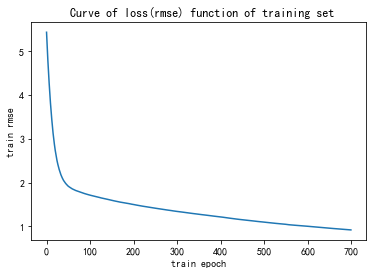

In [63]:
#导入必要的包

#计算与可视化
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

#评估指标、编码与模型
from  sklearn.metrics import accuracy_score,  auc, confusion_matrix, roc_auc_score, classification_report,cohen_kappa_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import xgboost as xgb
from scipy.optimize import fmin_powell
#from ml_metrics import quadratic_weighted_kappa

from wf_analyse.analyse import base

# 导入数据集 保险数据集-训练
 
import wfio 
# 读取并返回对应的Dataframe
# 参数as_spark: 为True返回Spark DataFrame，为False返回Pandas DataFrame，默认为False 
train = wfio.read_dataframe(_INPUT,as_spark = False)

# 导入数据集 保险数据集-测试-抽样
 
import wfio
 
# 读取并返回对应的Dataframe
# 参数as_spark: 为True返回Spark DataFrame，为False返回Pandas DataFrame，默认为False 
test = wfio.read_dataframe(_INPUT2,as_spark = False)

def eval_wrapper(yhat, y):  
    y = np.array(y)
    y = y.astype(int)
    yhat = np.array(yhat)
    yhat = np.clip(np.round(yhat), np.min(y), np.max(y)).astype(int)   
    return cohen_kappa_score(yhat, y, weights= 'quadratic')
    
    
def apply_offset(data, bin_offset, sv, scorer=eval_wrapper):
    # data has the format of pred=0, offset_pred=1, labels=2 in the first dim
    #data[0] = data[1]是预测值， data[2]是真实标签值
    #sv是是类别编号sv = 0(1, 2, 3, 4, 5, 6, 7)
    #把预测值等于sv这一类的样本预测值取出来 + bin_offset偏移量 作为新的预测值
    data[1, data[0].astype(int)==sv] = data[0, data[0].astype(int)==sv] + bin_offset
    score = scorer(data[1], data[2])
    return score

def new_target3(row):
    if (row['BMI_Wt']=='under_weight') or (row['Old_Young']=='young')  or (row['Thin_Fat']=='thin'):
        val='low_end'
    else:
        val='non_low_end'
    return val


def new_target1(row):
    if (row['BMI_Wt']=='overweight') or (row['Old_Young']=='old')  or (row['Thin_Fat']=='fat'):
        val='extremely_risky'
    else:
        val='not_extremely_risky'
    return val

def acc(y, yhat):  
    y = np.array(y)
    y = y.astype(int)
    yhat = np.array(yhat)
    yhat = np.clip(np.round(yhat), np.min(y), np.max(y)).astype(int)   
    return accuracy_score(y, yhat)

columns_to_drop = ['response']
xgb_num_rounds = 700
num_classes = 8

test_label = test["response"].copy()
test["response"] = -1000
# 将训练集与测试集拼接，并于统一特征处理
all_data = train.append(test)

# 创建新特征 
# 特征编码
all_data['product_info_2'] = pd.factorize(all_data['product_info_2'])[0]

print('Eliminate missing values')    
# 空值填充-1
all_data.fillna(-1, inplace=True)

# 将label转为int值
all_data['response'] = all_data['response'].astype(int)

# BMI离散化处理
conditions = [
    (all_data['bmi'] <= all_data['bmi'].quantile(0.25)),
    (all_data['bmi'] > all_data['bmi'].quantile(0.25)) & (all_data['bmi'] <= all_data['bmi'].quantile(0.75)),
    (all_data['bmi'] > all_data['bmi'].quantile(0.75))]

choices = ['under_weight', 'average', 'overweight']

all_data['BMI_Wt'] = np.select(conditions, choices)

# 年龄离散化处理
conditions = [
    (all_data['ins_age'] <= all_data['ins_age'].quantile(0.25)),
    (all_data['ins_age'] > all_data['ins_age'].quantile(0.25)) & (all_data['ins_age'] <= all_data['ins_age'].quantile(0.75)),
    (all_data['ins_age'] > all_data['ins_age'].quantile(0.75))]

choices = ['young', 'average', 'old']
all_data['Old_Young'] = np.select(conditions, choices)

# 身份离散化处理
conditions = [
    (all_data['ht'] <= all_data['ht'].quantile(0.25)),
    (all_data['ht'] > all_data['ht'].quantile(0.25)) & (all_data['ht'] <= all_data['ht'].quantile(0.75)),
    (all_data['ht'] > all_data['ht'].quantile(0.75))]

choices = ['short', 'average', 'tall']

all_data['Short_Tall'] = np.select(conditions, choices)

# 体重离散化处理
conditions = [
    (all_data['wt'] <= all_data['wt'].quantile(0.25)),
    (all_data['wt'] > all_data['wt'].quantile(0.25)) & (all_data['wt'] <= all_data['wt'].quantile(0.75)),
    (all_data['wt'] > all_data['wt'].quantile(0.75))]

choices = ['thin', 'average', 'fat']

all_data['Thin_Fat'] = np.select(conditions, choices)

##创建新特征
all_data['extreme_risk'] = all_data.apply(new_target1,axis=1)
#创建新特征
all_data['low_end_risk'] = all_data.apply(new_target3,axis=1) 

all_data['BMI_Wt'] = pd.factorize(all_data['BMI_Wt'])[0]
all_data['Old_Young'] = pd.factorize(all_data['Old_Young'])[0]
all_data['Short_Tall'] = pd.factorize(all_data['Short_Tall'])[0]
all_data['Thin_Fat'] = pd.factorize(all_data['Thin_Fat'])[0]
all_data['extreme_risk'] = pd.factorize(all_data['extreme_risk'])[0]
all_data['low_end_risk'] = pd.factorize(all_data['low_end_risk'])[0]

all_data.drop(["BMI_Wt", "Short_Tall","Thin_Fat","Old_Young"], axis=1, inplace = True)

def get_params():
    params = {}
    params["objective"] = "reg:linear"     
    params["eta"] = 0.05
    params["min_child_weight"] = 50
    params["subsample"] = 0.8
    params["colsample_bytree"] = 0.30
    params["silent"] = 1
    params["max_depth"] = 8
    plst = list(params.items())
    return plst

# 拆分数据集
train = all_data[all_data['response']>0].copy()
test = all_data[all_data['response']<1].copy()

# 转成xgb格式
xgtrain = xgb.DMatrix(train.drop(columns_to_drop, axis=1), train['response'].values)
xgtest = xgb.DMatrix(test.drop(columns_to_drop, axis=1), label=test_label.values)

# 获取模型参数
plst = get_params()

evals_process = dict()   #存储训练过程中的指标，便于后面loss曲线图
model = xgb.train(plst, xgtrain, xgb_num_rounds,evals=[(xgtrain, 'train'),(xgtest,'test')],verbose_eval=50, evals_result = evals_process)
#每50轮打印一次结果

#绘制训练集的训练过程中的loss曲线图
epoch = []  # 横坐标,迭代次数
for i in range(0, xgb_num_rounds, 1):
    epoch.append(i)

plt.plot(epoch, evals_process['train']["rmse"])
plt.ylabel('train rmse')
plt.xlabel('train epoch')
plt.title(" Curve of loss(rmse) function of training set")
plt.show()

In [64]:
#保存训练集在训练过程中的loss值，用于绘制loss变化曲线图
for i in range(0, xgb_num_rounds, 1):
    base.save_norm_by_step(model_name='xgbregression_train_loss', norm_name='loss',norm_value=np.float(evals_process['train']["rmse"][i]),step=i)
    #print(evals_process['train']["rmse"][i])

norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm

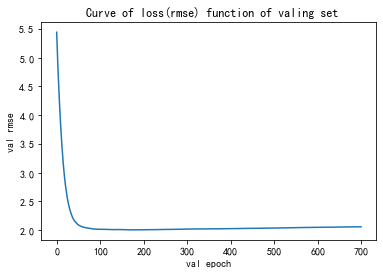

In [65]:
#绘制验证集在训练过程中的loss曲线图
epoch = []  # 横坐标,迭代次数
for i in range(0, xgb_num_rounds, 1):
    epoch.append(i)

plt.plot(epoch, evals_process['test']["rmse"])
# plt.plot([1,3,3,4], [1,4,9,16])
plt.ylabel('val rmse')
plt.xlabel('val epoch')
plt.title(" Curve of loss(rmse) function of valing set")
plt.show()

In [66]:
#全量数据保存
#保存测试集集在训练过程中的loss值，用于绘制loss变化曲线图
for i in range(0, xgb_num_rounds, 1):
    base.save_norm_by_step(model_name='xgbregression_test_loss', norm_name='loss',norm_value=np.float(evals_process['test']["rmse"][i]),step=i)
    #print(evals_process['test']["rmse"][i]

norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm

In [67]:
train_preds = model.predict(xgtrain, ntree_limit=model.best_iteration)
print('Train kappa score is:', eval_wrapper(train_preds, train['response']))
print('Train accuracy score is:', acc(train["response"], train_preds))

test_preds = model.predict(xgtest, ntree_limit=model.best_iteration)
print('Test kappa score is:', eval_wrapper( test_preds, test_label))

Train kappa score is: 0.9064031689141554
Train accuracy score is: 0.4730639730639731
Test kappa score is: 0.5102894842238563


In [68]:
base.save_norm(model_name='xgbregression', norm_name='Quadratic_Weighted_Kappa',norm_value=np.float(eval_wrapper( test_preds, test_label)), operate_type='test')           

norm validate success,begin saving...
access token is None, skipping transforming.


## Version 3 模型

至此全量运行形成 Version3 模型，我们看全量运行界面。

发现加完这两个特征后，“Quadratic_Weighted_Kappa”指标有所提升。

那么将这个信息反馈给数据分析师，可知这个操作可以提升模型的性能，所以分析师在接下来的分析中， 应该加入”extreme_risk“和”low_end_risk”特征；

## 再使用凸优化函数寻找最佳的数值分割点（Version 4）

数据分析师再使用凸优化函数optim寻找最佳的数值分割点，通过对比充分训练的模型在训练集上的预测偏差，将此类偏差应用到测试集上，提升模型的性能表现。



[0]	train-rmse:5.43023	test-rmse:5.44214
[50]	train-rmse:1.91910	test-rmse:2.09415
[100]	train-rmse:1.71346	test-rmse:2.01773
[150]	train-rmse:1.59576	test-rmse:2.01147
[200]	train-rmse:1.50021	test-rmse:2.00838
[250]	train-rmse:1.41626	test-rmse:2.01462
[300]	train-rmse:1.34297	test-rmse:2.02027
[350]	train-rmse:1.27718	test-rmse:2.02405
[400]	train-rmse:1.21821	test-rmse:2.02797
[450]	train-rmse:1.15243	test-rmse:2.03345
[500]	train-rmse:1.09874	test-rmse:2.03891
[550]	train-rmse:1.04796	test-rmse:2.04545
[600]	train-rmse:1.00418	test-rmse:2.05091
[650]	train-rmse:0.95989	test-rmse:2.05555
[699]	train-rmse:0.92127	test-rmse:2.06074


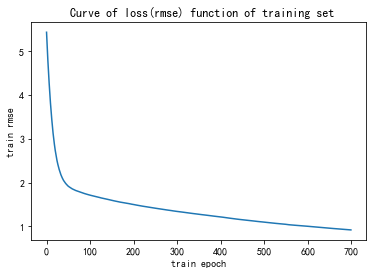

In [69]:
train = all_data[all_data['response']>0].copy()
test = all_data[all_data['response']<1].copy()

# 转成xgb格式
xgtrain = xgb.DMatrix(train.drop(columns_to_drop, axis=1), train['response'].values)
xgtest = xgb.DMatrix(test.drop(columns_to_drop, axis=1), label=test_label.values)

# 获取模型参数
plst = get_params()
evals_process = dict()   #存储训练过程中的指标，便于后面loss曲线图
model = xgb.train(plst, xgtrain, xgb_num_rounds,evals=[(xgtrain, 'train'),(xgtest,'test')],verbose_eval=50, evals_result = evals_process)

#绘制训练集的训练过程中的loss曲线图
epoch = []  # 横坐标,迭代次数
for i in range(0, xgb_num_rounds, 1):
    epoch.append(i)

plt.plot(epoch, evals_process['train']["rmse"])
plt.ylabel('train rmse')
plt.xlabel('train epoch')
plt.title(" Curve of loss(rmse) function of training set")
plt.show()

In [70]:
#保存训练集在训练过程中的loss值，用于绘制loss变化曲线图
for i in range(0, xgb_num_rounds, 1):
    base.save_norm_by_step(model_name='train', norm_name='loss',norm_value=np.float(evals_process['train']["rmse"][i]),step=i)
    #print(evals_process['train']["rmse"][i])
    


norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm

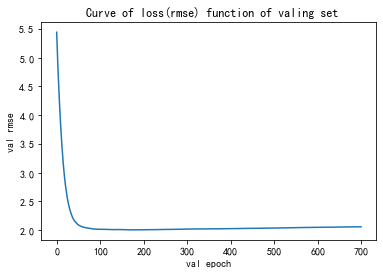

In [71]:
#绘制验证集在训练过程中的loss曲线图
epoch = []  # 横坐标,迭代次数
for i in range(0, xgb_num_rounds, 1):
    epoch.append(i)

plt.plot(epoch, evals_process['test']["rmse"])
# plt.plot([1,3,3,4], [1,4,9,16])
plt.ylabel('val rmse')
plt.xlabel('val epoch')
plt.title(" Curve of loss(rmse) function of valing set")
plt.show()

In [72]:
#全量数据保存
#保存测试集集在训练过程中的loss值，用于绘制loss变化曲线图
for i in range(0, xgb_num_rounds, 1):
    base.save_norm_by_step(model_name='validation', norm_name='loss',norm_value=np.float(evals_process['test']["rmse"][i]),step=i)
    #print(evals_process['test']["rmse"][i]
    


norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm

In [73]:
train_preds = model.predict(xgtrain, ntree_limit=model.best_iteration)
print('Train kappa score is:', eval_wrapper(train_preds, train['response']))
print('Train accuracy score is:', acc(train["response"], train_preds))

test_preds = model.predict(xgtest, ntree_limit=model.best_iteration)
print('Test kappa score is:', eval_wrapper( test_preds, test_label))

train_preds = np.clip(train_preds, -0.99, 8.99)
test_preds = np.clip(test_preds, -0.99, 8.99)

# 设置偏移量，并使用fmin_powell寻找最佳值
offsets = np.ones(num_classes) * -0.3
offset_train_preds = np.vstack((train_preds, train_preds, train['response'].values))
for j in range(num_classes):
    train_offset = lambda x: -apply_offset(offset_train_preds, x, j)
    #def train_offset(x):
    #   -apply_offset(offset_train_preds, x, j)
    offsets[j] = fmin_powell(train_offset, offsets[j])  

# 将在训练集上的偏移量应用在测试集上
data = np.vstack((test_preds, test_preds, test['response'].values))
for j in range(num_classes):
    data[1, data[0].astype(int)==j] = data[0, data[0].astype(int)==j] + offsets[j] 

final_test_preds = np.round(np.clip(data[1], 1, 8)).astype(int)

print('Test kappa score is:', eval_wrapper( final_test_preds, test_label))

base.save_norm(model_name='xgbregression_offset', norm_name='Quadratic_Weighted_Kappa',norm_value=np.float(eval_wrapper( final_test_preds, test_label)), operate_type='test')       



Train kappa score is: 0.9064031689141554
Train accuracy score is: 0.4730639730639731
Test kappa score is: 0.5102894842238563
Optimization terminated successfully.
         Current function value: -0.906403
         Iterations: 1
         Function evaluations: 14
Optimization terminated successfully.
         Current function value: -0.909131
         Iterations: 2
         Function evaluations: 40
Optimization terminated successfully.
         Current function value: -0.923228
         Iterations: 2
         Function evaluations: 49
Optimization terminated successfully.
         Current function value: -0.937336
         Iterations: 2
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: -0.937777
         Iterations: 3
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -0.939746
         Iterations: 2
         Function evaluations: 28
Optimization terminated successfully.
         

# Version 4 模型

通过全量运行即可形成 Version 4 版本的模型，该版本的评估指标 "Quadratic_Weighted_Kappa" 达到了 0.657，属于目前该数据集预测结果的最佳水准。

至此整个数据分析流程结束，我们可以通过全量运行记录与其他模型进行对比。

## 结果申报审核

数据分析师将全量运行的模型与偏移量列表存入文件，并申报带走这两个运行结果，用于模型预测服务的部署。

In [74]:
import pickle 

# 保存 offset 数组
pickle.dump(offsets, open("final_offset.list", "wb"))
# 保存 xgboost 模型
pickle.dump(model, open("xgboost.model", "wb"))

# 将 offset 数组上传至 oss 
wfio.upload_to_oss("final_offset.list", "./final_offset.list")
# 将 xgboost 模型上传至 oss 
wfio.upload_to_oss("xgboost.model", "./xgboost.model")

当前环境 [调试环境] 禁止上传到oss 文件系统 
当前环境 [调试环境] 禁止上传到oss 文件系统 
